In [51]:
###########################################################################################################
#TRABAJO FINAL - METODOLOGIA DE LA ANALISIS PARA LA OPINION PUBLICA - CATEDRA: OLEGO
#AUTORES: MERCEDES PATRICIA, LA ROSA SANTORO, PERLASCA TOMÁS, FRANCO CHIRI
#FECHA: 25/11/2025
###########################################################################################################

## 0. Importamos paquetes necesarios para el trabajo ####

In [52]:
import pandas as pd #importamos pandas para los dataframes
import numpy  as np # pa los calculos numéricos
import matplotlib.pyplot as plt #pa los graficos
import seaborn as sns #pa los graficos
import scipy.stats as stats #pa los calculos estadisticos
import sklearn as sk #para la regresion logistica

## 1.Lectura del CSV ####

In [53]:
pd.read_csv("encuestas_1000_casos.csv") #leemos el csv
df=pd.read_csv("encuestas_1000_casos.csv") #lo designamos a una dataframe
print (df) #mostramos el dataframe

          Fecha  Encuesta              Estrato       Sexo  Edad  \
0    2025-02-01       200              Tucumán  Masculino  42.0   
1    2025-03-01       400             San Luis  Masculino  36.0   
2    2025-03-01       400  Santiago del Estero  Masculino  26.0   
3    2025-03-01       400           Entre Ríos  Masculino  63.0   
4    2025-02-15       300           Entre Ríos  Masculino  37.0   
..          ...       ...                  ...        ...   ...   
995  2025-02-15       300           Santa Cruz  Masculino  60.0   
996  2025-02-01       200             La Pampa   Femenino  21.0   
997  2025-02-15       300  Santiago del Estero   Femenino  25.0   
998  2025-02-15       300           Corrientes  Masculino  70.0   
999  2025-03-01       400                Salta  Masculino  45.0   

                        Nivel Educativo  Cantidad de Integrantes en el Hogar  \
0                              Posgrado                                    1   
1                     Primario comp

## 2. Informacion general y limpieza de datos ####  

In [54]:
print(df.isnull().sum()) #vemos cuantos nulos hay
print(df.columns.tolist()) #vemos las columnas como una lista
print(df.info()) #info general del df
[col for col in df.columns if "fecha" in col.lower()] #buscamos columna fecha para ver nombre exacto
#como la fecha va a ser lo que indexemos la unificamos antes que nada
df.columns = df.columns.str.lower().str.replace(" ","_") #normalizamos nombres columnas
df = df.drop_duplicates() #eliminamos filas duplicadas
print(df.columns.tolist()) #printeamos los cambios de nombres de las columnas
print(df.isnull().sum())  # vemos que no hay nulos
print(df.info()) # mostramos informacion del dataframe luego de la limpieza
print(df.describe())# mostramos estadisticas descriptivas del dataframe

Fecha                                   0
Encuesta                                0
Estrato                                 0
Sexo                                    0
Edad                                   48
Nivel Educativo                        21
Cantidad de Integrantes en el Hogar     0
Imagen del Candidato                    8
Voto                                   30
Voto Anterior                           0
dtype: int64
['Fecha', 'Encuesta', 'Estrato', 'Sexo', 'Edad', 'Nivel Educativo', 'Cantidad de Integrantes en el Hogar', 'Imagen del Candidato', 'Voto', 'Voto Anterior']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Fecha                                1000 non-null   object 
 1   Encuesta                             1000 non-null   int64  
 2   Estrato                             

## 3.Tracking imagen del candidato ####

In [55]:
#como la fecha dice objets significa que la columna es string y no sirve para rolling por tiempo entonces:
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce') # convertimos la columna 'fecha' a tipo datetime
df = df.dropna(subset=['fecha']) #eliminamos filas donde 'fecha' no se pudo convertir  a datetime
#podemos llenar con la media o la moda en vez de eliminar nulos, pero en este caso no hay nulos en fecha, pero si puede ser en otras columnas para el analisis posterior
print(df.columns.tolist())
print(df["fecha"].dtype) #confirmamos que la fecha sea el formato correcto para poder aplicar rolling window
df["edad"] = df["edad"].astype("Int64")  # convertimos edad que era float a entero
print(df["edad"].dtype) #confirmamos que edad es int
df.set_index('fecha', inplace=True) #columna fecha como índice del df
df.sort_index(inplace=True) #ordenamos el df por el índice de fecha ya que es el "título" de cada fila
imagen_diaria = df["imagen_del_candidato"].resample("D").mean() #imagen x día
imagen_rolling = imagen_diaria.rolling("7D").mean()
print(imagen_rolling) #ahora si tenemos un dato por día, el promedio de todas las encuestas de ese día
# ahora podemos ver una fila por dia porque el rolling se aplica a un dato por dia que es la media diaria
# sirve en casos donde hay mas de una encuesta por dia

['fecha', 'encuesta', 'estrato', 'sexo', 'edad', 'nivel_educativo', 'cantidad_de_integrantes_en_el_hogar', 'imagen_del_candidato', 'voto', 'voto_anterior']
datetime64[ns]
Int64
fecha
2025-01-15    68.812500
2025-01-16    68.812500
2025-01-17    68.812500
2025-01-18    68.812500
2025-01-19    68.812500
2025-01-20    68.812500
2025-01-21    68.812500
2025-01-22          NaN
2025-01-23          NaN
2025-01-24          NaN
2025-01-25          NaN
2025-01-26          NaN
2025-01-27          NaN
2025-01-28          NaN
2025-01-29          NaN
2025-01-30          NaN
2025-01-31          NaN
2025-02-01    79.619048
2025-02-02    79.619048
2025-02-03    79.619048
2025-02-04    79.619048
2025-02-05    79.619048
2025-02-06    79.619048
2025-02-07    79.619048
2025-02-08          NaN
2025-02-09          NaN
2025-02-10          NaN
2025-02-11          NaN
2025-02-12          NaN
2025-02-13          NaN
2025-02-14          NaN
2025-02-15    65.969388
2025-02-16    65.969388
2025-02-17    65.969388
2

## 4.Tracking intencion de voto ####

In [56]:
#buscamos dentro de la columna voto del dataframe el string que contenga ciertas caracterisiticas
# y si el caso es falso lo desestima y lo pone en default, para los casos true crea un nuevo data frame que se llama voto limpio
# el cual vamos a usar para hacer el resto de las funciones
df["voto_limpio"] = np.select(
    [
        df["voto"].str.contains("candidato a",case=False,na=False),
        df["voto"].str.contains("candidato b",case=False,na=False),
        df["voto"].str.contains("candidato c",case=False,na=False),
        df["voto"].str.contains("blanco",case=False, na=False),
        df["voto"].str.contains("vota",case=False, na=False),
    ],
    [
        "Candidato A",
        "Candidato B",
        "Candidato C",
        "En blanco",
        "No vota",
    ],
    default="Otro"
)
print(df["voto_limpio"])
conteo2 = df.groupby(['fecha','voto_limpio']).size().unstack(fill_value=0) # conteo diario de casos x candidato
totales = conteo2.sum(axis=1) # total casos x día
porcentaje_diario2 = conteo2.div(totales,axis=0)*100 # porcentaje diario de votos por candidato (fórmula V_C,t / N_t * 100)
porcentaje_rolling2 = porcentaje_diario2.rolling("7D").mean() # rolling window de 7 días que se puede ir modificando
print(porcentaje_rolling2.head())
porcentaje_diario2 = porcentaje_diario2.round(2)  #modificamos cantidad de decimales a 2
print(porcentaje_diario2.astype(str)+"%") # mostramos porcentajes diarios con símbolo % de cada candidato

fecha
2025-01-15    Candidato B
2025-01-15    Candidato B
2025-01-15    Candidato B
2025-01-15      En blanco
2025-01-15    Candidato A
                 ...     
2025-03-01    Candidato C
2025-03-01    Candidato C
2025-03-01    Candidato C
2025-03-01        No vota
2025-03-01        No vota
Name: voto_limpio, Length: 841, dtype: object
voto_limpio  Candidato A  Candidato B  Candidato C  En blanco    No vota  \
fecha                                                                      
2025-01-15     19.209040    25.423729    27.118644  20.903955   3.954802   
2025-02-01     20.158103    11.067194    14.624506  33.201581  18.577075   
2025-02-15     17.085427     4.020101    28.643216  14.070352  29.648241   
2025-03-01     22.641509    18.867925    19.339623  22.169811  14.622642   

voto_limpio      Otro  
fecha                  
2025-01-15   3.389831  
2025-02-01   2.371542  
2025-02-15   6.532663  
2025-03-01   2.358491  
voto_limpio Candidato A Candidato B Candidato C En blanco No 

## 6. Analisis Estadistico ####

## 6.1 Normalizacion de los datos de INDEC Censo 2022 y la Encuesta ###

In [57]:
#ANALISIS ESTADISTICO
#6.1 Analisis estadistico - NORMALIZACION DE LOS DATOS DE INDEC CENSO 2022 y LA ENCUESTA

# en el dataframe de la encuesta vamos a eliminar los outliers de la columna edad (personas <18 y >95 años)
df_encuesta_estadistico = df[(df['edad'] >= 18) & (df['edad'] <= 95)] # filtramos edades validas
print(df_encuesta_estadistico['edad'].describe()) # mostramos estadisticas descriptivas de la columna edad luego de eliminar outliers
#la decision de realizarlo de esta manera y no por IQR es para eliminar por criterio logico
df_encuesta_estadistico = df_encuesta_estadistico.dropna() # eliminamos filas con nulos en edad si los hubiera

df_encuesta_estadistico.dtypes

# cargamos ahora el censo 2022 para poder ponderar las encuestas segun la poblacion real y adjuntarlo a la dataframe de las encuestas
pd.read_csv("censo_2022_v_final.csv") #leemos el csv del censo
df_censo=pd.read_csv("censo_2022_v_final.csv") #lo designamos a una dataframe
print (df_censo) #mostramos el dataframe del censo
print(df_censo.isnull().sum()) #vemos cuantos nulos hay en el censo
print(df_censo.columns.tolist()) #vemos las columnas del censo como una lista

# normalizamos nombres columnas del censo
df_censo.columns = df_censo.columns.str.lower().str.strip()
df_censo['estrato'] = df_censo['estrato'].str.lower().str.strip()
df_censo['sexo'] = df_censo['sexo'].str.lower().str.strip()

# normlaizamos la encuesta tambien
# normalizamos encuesta
df_encuesta_estadistico.columns = df_encuesta_estadistico.columns.str.lower().str.strip()
df_encuesta_estadistico['estrato'] = df_encuesta_estadistico['estrato'].str.lower().str.strip()
df_encuesta_estadistico['sexo'] = df_encuesta_estadistico['sexo'].str.lower().str.strip()
#calculamos el peso del censo

# población total del país según el archivo
poblacion_total = df_censo['poblacion'].sum()

# peso = proporción de población que representa ese grupo (estrato+sexo+edad)
df_censo['peso'] = df_censo['poblacion'] / poblacion_total

# esta es la tabla maestra que vamos a mergear
tabla_pesos = df_censo[['estrato','sexo','edad','peso']]
print(tabla_pesos)

# ahora mergeamos la tabla de pesos con el dataframe de encuestas

df_ponderado = pd.merge(df_encuesta_estadistico, tabla_pesos, how='left', left_on=['estrato','sexo','edad'], right_on=['estrato','sexo','edad'])
print(df_ponderado)



count        794.0
mean      47.77204
std      17.579427
min           18.0
25%           33.0
50%           46.0
75%           63.0
max           80.0
Name: edad, dtype: Float64
      codigo_estrato           estrato       sexo  edad  poblacion
0                  2              Caba   femenino    16      17153
1                  2              Caba  masculino    16      17213
2                  2              Caba   femenino    17      17923
3                  2              Caba  masculino    17      17905
4                  2              Caba   femenino    18      19907
...              ...               ...        ...   ...        ...
3995              23  Tierra del Fuego  masculino    93       6532
3996              23  Tierra del Fuego   femenino    94      13360
3997              23  Tierra del Fuego  masculino    94       4992
3998              23  Tierra del Fuego   femenino    95      10188
3999              23  Tierra del Fuego  masculino    95       3781

[4000 rows x 5 c

codigo_estrato    0
estrato           0
sexo              0
edad              0
poblacion         0
dtype: int64
['codigo_estrato', 'estrato', 'sexo', 'edad', 'poblacion']
               estrato       sexo  edad      peso
0                 caba   femenino    16  0.000246
1                 caba  masculino    16  0.000247
2                 caba   femenino    17  0.000257
3                 caba  masculino    17  0.000257
4                 caba   femenino    18  0.000286
...                ...        ...   ...       ...
3995  tierra del fuego  masculino    93  0.000094
3996  tierra del fuego   femenino    94  0.000192
3997  tierra del fuego  masculino    94  0.000072
3998  tierra del fuego   femenino    95  0.000146
3999  tierra del fuego  masculino    95  0.000054

[4000 rows x 4 columns]
     encuesta     estrato       sexo  edad  \
0         100     formosa   femenino    77   
1         100    san juan   femenino    22   
2         100     córdoba  masculino    34   
3         100    la

In [58]:
############################################################################################################
#ALTERNATIVA A UTILIZANDO FUNCIONES 
#import pandas as pd

# COLUMNS NEEDED
#COLUMNS_NEEDED = ['estrato', 'sexo', 'edad']

# CARGA DE DATOS SEGURO
#try:
    #df = pd.read_csv('encuesta.csv')
#except Exception as e:
    #print(f"Error al cargar encuesta: {e}")
    #df = pd.DataFrame()  # DataFrame vacío para evitar romper

#try:
    #df_censo = pd.read_csv('censo_2022_v_final.csv')
#except Exception as e:
    #print(f"Error al cargar censo: {e}")
    #df_censo = pd.DataFrame()
    
# NORMALIZAR NOMBRES DE COLUMNAS
#df.columns = df.columns.str.lower().str.strip()
#df_censo.columns = df_censo.columns.str.lower().str.strip()

# Revisar si están todas las columnas necesarias
#for col in COLUMNS_NEEDED:
    #if col not in df.columns:
        #print(f"Columna faltante en encuesta: {col}")
        # Agrega la columna vacía para evitar romper
        #df[col] = None
    #if col not in df_censo.columns:
        #print(f"Columna faltante en censo: {col}")
        #df_censo[col] = None

# NORMALIZAR DATOS DENTRO DE LAS COLUMNAS (lambdas)
#for columna in ['estrato', 'sexo']:
    #df_censo[columna] = df_censo[columna].astype(str).map(lambda x: x.strip().lower() if pd.notna(x) else "")
    #df[columna] = df[columna].astype(str).map(lambda x: x.strip().lower() if pd.notna(x) else "")

# LIMPIEZA DE EDAD Y FILTRO (filtro lógico con if/else en lambda)
#df['edad'] = pd.to_numeric(df['edad'], errors='coerce')  # fuerza edad a número o NaN

#df_encuesta_estadistico = df.loc[
#    df['edad'].map(lambda x: True if pd.notna(x) and 18 <= x <= 95 else False)
#].dropna(subset=['edad'])  # elimina filas solo si edad es nula
#print(df_encuesta_estadistico['edad'].describe())

# LAMBDAS EN FALLBACKS
# Si hay columnas adicionales inesperadas, las ignoramos en los pasos posteriores.

# CALCULAMOS EL PESO
# if 'poblacion' in df_censo.columns:
#     poblacion_total = df_censo['poblacion'].sum()
#     df_censo['peso'] = df_censo['poblacion'] / poblacion_total if poblacion_total > 0 else 0
# else:
#     print("Columna 'poblacion' faltante en censo.")
#     df_censo['peso'] = 0

# PREPARAR TABLA DE PESOS SOLO SI EXISTEN LAS COLUMNAS NECESARIAS
#cols_peso = ['estrato', 'sexo', 'edad', 'peso']
#for col in cols_peso:
    #if col not in df_censo.columns:
        #df_censo[col] = None
#tabla_pesos = df_censo[cols_peso]

# MERGE DE DATAFRAMES
#df_ponderado = pd.merge(
    #df_encuesta_estadistico, tabla_pesos,
    #how='left',
    #left_on=['estrato', 'sexo', 'edad'],
    #right_on=['estrato', 'sexo', 'edad'])
#print(df_ponderado.head())

# OPCIONAL: MENSAJES SI HAY MUCHO NULO EN PESO
#if df_ponderado['peso'].isnull().mean() > 0.1:
    #print("Más del 10% de las filas no pudieron ser ponderadas porque no encontraron coincidencia en el censo.")

## 6.2 Moda, Mediana y Media ###

In [59]:
#Calculamos las modas, medianas y medias de las variables

moda_edad = df_ponderado['edad'].mode()[0]
print("Moda de edad:", moda_edad)
moda_sexo = df_ponderado['sexo'].mode()[0]
print("Moda de sexo:", moda_sexo)
moda_estrato = df_ponderado['estrato'].mode()[0]
print("Moda de estrato:", moda_estrato)
moda_nivel_educativo = df_ponderado['nivel_educativo'].mode()[0]
print("Moda de nivel educativo:", moda_nivel_educativo)
moda_voto_limpio = df_ponderado['voto_limpio'].mode()[0]
print("Moda de voto limpio:", moda_voto_limpio)
moda_voto_anterior = df_ponderado['voto_anterior'].mode()[0]
print("Moda de voto anterior:", moda_voto_anterior)
moda_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].mode()[0]
print("Moda de cantidad de integrantes del hogar:", moda_cantidad_de_integrantes_hogar) 
moda_imagen_del_candidato = df_ponderado['imagen_del_candidato'].mode()[0]
print("Moda de imagen del candidato:", moda_imagen_del_candidato)

Moda de edad: 60
Moda de sexo: masculino
Moda de estrato: tierra del fuego
Moda de nivel educativo: Primario incompleto
Moda de voto limpio: En blanco
Moda de voto anterior: Candidato B
Moda de cantidad de integrantes del hogar: 2
Moda de imagen del candidato: 79.0


In [60]:
####################################################################################
# Alternativa para las modas con funciones 
#columnas_moda = [
#    ("edad", "Edad"),
#    ("sexo", "Sexo"),
#    ("estrato", "Estrato"),
#    ("nivel_educativo", "Nivel educativo"),
#    ("voto_limpio", "Voto limpio"),
#    ("voto_anterior", "Voto anterior"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato"),
#]

#for col, nombre_legible in columnas_moda:
#    if col in df_ponderado.columns:
#        try:
#            # Solo obtenemos la moda si hay valores no nulos
#            serie = df_ponderado[col].dropna()
#            if not serie.empty:
#                moda = serie.mode()
#                # Hay columnas que pueden tener varias modas, nos quedamos con la primera si hay más de una.
#                valor_moda = moda[0] if not moda.empty else "No hay moda"
#                print(f"Moda de {nombre_legible}: {valor_moda}")
#            else:
#                print(f"Moda de {nombre_legible}: Sin datos válidos")
#        except Exception as e:
#            print(f"Error al calcular la moda de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

In [61]:
#calculamos mediana de las varaibles, edad, cantidad de hogares e imagen del candidato
mediana_edad = df_ponderado['edad'].median()
print("Mediana de edad:", mediana_edad)
mediana_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].median()
print("Mediana de cantidad de integrantes del hogar:", mediana_cantidad_de_integrantes_hogar)
mediana_imagen_del_candidato = df_ponderado['imagen_del_candidato'].median()
print("Mediana de imagen del candidato:", mediana_imagen_del_candidato)

Mediana de edad: 46.0
Mediana de cantidad de integrantes del hogar: 3.0
Mediana de imagen del candidato: 78.0


In [62]:
####################################################################################################
#ALTERNATIVA PARA EL CALCULO DE MEDIANAS UTILIZANDO FUNCIONES
#columnas_medianas = [
#    ("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato")
#]
#for col, nombre_legible in columnas_medianas:
#    if col in df_ponderado.columns:
#        try:
#            serie = df_ponderado[col].dropna()
#            if not serie.empty:
#                # Para asegurarnos que son datos numéricos
#                serie = pd.to_numeric(serie, errors="coerce").dropna()
#                if not serie.empty:
#                    mediana = serie.median()
#                    print(f"Mediana de {nombre_legible}: {mediana}")
#                else:
#                    print(f"Mediana de {nombre_legible}: Sin datos numéricos válidos")
#            else:
#                print(f"Mediana de {nombre_legible}: Sin datos válidos")
#        except Exception as e:
#            print(f"Error al calcular la mediana de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

In [63]:
#calculamos la media arimetica y ponderada de la edad, cantidad de integrantes en el hogar e imagen del candidato

media_edad = df_ponderado['edad'].mean()
print("Media de edad:", media_edad)
media_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].mean()
print("Media de cantidad de integrantes del hogar:", media_cantidad_de_integrantes_hogar)
media_imagen_del_candidato = df_ponderado['imagen_del_candidato'].mean()
print("Media de imagen del candidato:", media_imagen_del_candidato)
print( "-----------------------------------------------------------------------------------------")
media_edad_ponderado = np.average(df_ponderado['edad'], weights=df_ponderado['peso'])
print("Media ponderada de edad:", media_edad_ponderado)
media_cantidad_de_integrantes_hogar_ponderado = np.average(df_ponderado['cantidad_de_integrantes_en_el_hogar'], weights=df_ponderado['peso'])   
print("Media ponderada de cantidad de integrantes del hogar:", media_cantidad_de_integrantes_hogar_ponderado)
media_imagen_del_candidato_ponderado = np.average(df_ponderado['imagen_del_candidato'], weights=df_ponderado['peso'])
print("Media ponderada de imagen del candidato:", media_imagen_del_candidato_ponderado)

Media de edad: 47.620957309184995
Media de cantidad de integrantes del hogar: 3.4527813712807243
Media de imagen del candidato: 74.02975420439844
-----------------------------------------------------------------------------------------
Media ponderada de edad: 42.47669730745464
Media ponderada de cantidad de integrantes del hogar: 3.5428747096647735
Media ponderada de imagen del candidato: 76.44490926317413


In [64]:
############################################################################################
# Alternativa para el calculo de medias utilizando funciones
#import numpy as np  # ¡Asegúrate de importar numpy!

#columnas_media = [
#    from narwhals import col


#("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato")]

#peso_col = "peso"  # nombre de la columna de pesos, puedes cambiarlo si tu script usa otro

#for col, nombre_legible in columnas_media:
#    if col in df_ponderado.columns:
#        try:
#            serie = df_ponderado[col].dropna()
#            if not serie.empty:
#                # Aseguramos que sean números:
#                serie = pd.to_numeric(serie, errors="coerce").dropna()
#                if not serie.empty:
#                    media = serie.mean()
#                    print(f"Media de {nombre_legible}: {media}")
#                    
#                    # --- media ponderada
#                    if peso_col in df_ponderado.columns:
#                        pesos = pd.to_numeric(df_ponderado[peso_col], errors="coerce").fillna(0)
#                        if (len(pesos) == len(serie)):  # Misma longitud obligatoria
#                            # Filtramos donde ambos, valor y peso, no sean nulos
#                            valores_validos = serie.index.intersection(pesos.dropna().index)
#                            if not valores_validos.empty:
#                                media_pond = np.average(serie.loc[valores_validos], weights=pesos.loc[valores_validos])
#                                print(f"Media ponderada de {nombre_legible}: {media_pond}")
#                            else:
#                                print(f"Media ponderada de {nombre_legible}: Sin datos válidos para ponderar")
#                        else:
#                            print(f"Media ponderada de {nombre_legible}: Diferente cantidad de datos vs. pesos")
#                    else:
#                        print(f"No existe la columna de peso '{peso_col}' para ponderar {nombre_legible}")
#                else:
#                    print(f"Media de {nombre_legible}: Sin datos numéricos válidos")
#            else:
#                print(f"Media de {nombre_legible}: Sin datos válidos")
#        except Exception as e:
#            print(f"Error al calcular la media de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

#print("-----------------------------------------------------------------------------------------")

## 6.3 Cuartiles, calculo de varianza, desvio estandar, coeficiente de variacion numerica, rango y rango intercuantilico ###

In [65]:
# cuartiles de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
cuartiles_edad = df_ponderado['edad'].quantile([0.25, 0.5, 0.75])
print("Cuartiles de edad:\n", cuartiles_edad)
cuartiles_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].quantile([0.25, 0.5, 0.75])
print("Cuartiles de cantidad de integrantes del hogar:\n", cuartiles_cantidad_de_integrantes_hogar)
cuartiles_imagen_del_candidato = df_ponderado['imagen_del_candidato'].quantile([0.25, 0.5, 0.75])       
print("Cuartiles de imagen del candidato:\n", cuartiles_imagen_del_candidato)

Cuartiles de edad:
 0.25    33.0
0.50    46.0
0.75    63.0
Name: edad, dtype: Float64
Cuartiles de cantidad de integrantes del hogar:
 0.25    2.0
0.50    3.0
0.75    5.0
Name: cantidad_de_integrantes_en_el_hogar, dtype: float64
Cuartiles de imagen del candidato:
 0.25    61.0
0.50    78.0
0.75    89.0
Name: imagen_del_candidato, dtype: float64


In [66]:
########################################################
# Alternativa para el calculo de cuartiles utilizando funciones
#columnas_cuartiles = [
#    ("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato")
#]

#for col, nombre_legible in columnas_cuartiles:
#    if col in df_ponderado.columns:
#        try:
#            serie = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#            if not serie.empty:
#                cuartiles = serie.quantile([0.25, 0.5, 0.75])
#                print(f"Cuartiles de {nombre_legible}:\n{cuartiles}")
#            else:
#                print(f"Cuartiles de {nombre_legible}: Sin datos numéricos válidos")
#        except Exception as e:
#            print(f"Error al calcular los cuartiles de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

In [67]:
# Rango y rango intercuartilico (IQR) 
rango_edad = df_ponderado['edad'].max() - df_ponderado['edad'].min()
print("Rango de edad:", rango_edad)
rango_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].max() - df_ponderado['cantidad_de_integrantes_en_el_hogar'].min()
print("Rango de cantidad de integrantes del hogar:", rango_cantidad_de_integrantes_hogar)
rango_imagen_del_candidato = df_ponderado['imagen_del_candidato'].max() - df_ponderado['imagen_del_candidato'].min()
print("Rango de imagen del candidato:", rango_imagen_del_candidato)
print( "===================================================================")
iqr_edad = cuartiles_edad[0.75] - cuartiles_edad[0.25]
print("IQR de edad:", iqr_edad)
iqr_cantidad_de_integrantes_hogar = cuartiles_cantidad_de_integrantes_hogar[0.75] - cuartiles_cantidad_de_integrantes_hogar[0.25]
print("IQR de cantidad de integrantes del hogar:", iqr_cantidad_de_integrantes_hogar)
iqr_imagen_del_candidato = cuartiles_imagen_del_candidato[0.75] - cuartiles_imagen_del_candidato[0.25]
print("IQR de imagen del candidato:", iqr_imagen_del_candidato)


Rango de edad: 62
Rango de cantidad de integrantes del hogar: 5
Rango de imagen del candidato: 60.0
IQR de edad: 30.0
IQR de cantidad de integrantes del hogar: 3.0
IQR de imagen del candidato: 28.0


In [68]:
################################################################
# Alternativa para el calculo de rangos e IQR utilizando funciones
#columnas_rango = [
#    ("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato")
#]

#for col, nombre_legible in columnas_rango:
#    if col in df_ponderado.columns:
#        try:
#            serie = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#            if not serie.empty:
#                rango = serie.max() - serie.min()
#                print(f"Rango de {nombre_legible}: {rango}")
#            else:
#                print(f"Rango de {nombre_legible}: Sin datos numéricos válidos")
#        except Exception as e:
#            print(f"Error al calcular el rango de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

#print("===================================================================")

#for col, nombre_legible in columnas_rango:
#    if col in df_ponderado.columns:
#        try:
#            serie = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#            if not serie.empty:
#                cuartiles = serie.quantile([0.25, 0.75])
#                if 0.75 in cuartiles.index and 0.25 in cuartiles.index:
#                    iqr = cuartiles[0.75] - cuartiles[0.25]
#                    print(f"IQR de {nombre_legible}: {iqr}")
#                else:
#                    print(f"IQR de {nombre_legible}: Cuartiles no disponibles")
#            else:
#                print(f"IQR de {nombre_legible}: Sin datos numéricos válidos")
#        except Exception as e:
#            print(f"Error al calcular el IQR de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

In [69]:
# Desviacion estandar y varianza de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
desvio_edad = df_ponderado['edad'].std()
print("Desviación estándar de edad:", desvio_edad)
desvio_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].std()
print("Desviación estándar de cantidad de integrantes del hogar:", desvio_cantidad_de_integrantes_hogar)
desvio_imagen_del_candidato = df_ponderado['imagen_del_candidato'].std()
print("Desviación estándar de imagen del candidato:", desvio_imagen_del_candidato)
print( "==================================================================")
varianza_edad = df_ponderado['edad'].var()
print("Varianza de edad:", varianza_edad)
varianza_cantidad_de_integrantes_hogar = df_ponderado["cantidad_de_integrantes_en_el_hogar"].var()
print("Varianza de cantidad de integrantes del hogar:", varianza_cantidad_de_integrantes_hogar)
varianza_imagen_del_candidato = df_ponderado["imagen_del_candidato"].var()
print("Varianza de imagen del candidato:", varianza_imagen_del_candidato)

#Desviacion estandar y varianza ponderada de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
desvio_edad_ponderado = np.sqrt(np.cov(df_ponderado['edad'], aweights=df_ponderado['peso']))
print("Desviación estándar ponderada de edad:", desvio_edad_ponderado)
Desvio_cantidad_de_integrantes_en_el_hogar_ponderado = np.sqrt(np.cov(df_ponderado ["cantidad_de_integrantes_en_el_hogar"], aweights=df_ponderado['peso']))
print("Desviación estándar ponderada de cantidad de integrantes del hogar:", Desvio_cantidad_de_integrantes_en_el_hogar_ponderado)
desvio_imagen_del_candidato_ponderado = np.sqrt(np.cov(df_ponderado['imagen_del_candidato'], aweights=df_ponderado['peso']))
print("Desviación estándar ponderada de imagen del candidato:", desvio_imagen_del_candidato_ponderado)
print("----------------------------------------------------------------")
varianza_edad_ponderado = np.cov(df_ponderado['edad'], aweights=df_ponderado['peso'])
print("Varianza ponderada de edad:", varianza_edad_ponderado)
varianza_cantidad_de_integrantes_en_el_hogar_ponderado = np.cov(df_ponderado["cantidad_de_integrantes_en_el_hogar"], aweights=df_ponderado['peso'])
print("Varianza ponderada de cantidad de integrantes del hogar:", varianza_cantidad_de_integrantes_en_el_hogar_ponderado)
varianza_imagen_del_candidato_ponderado = np.cov(df_ponderado['imagen_del_candidato'], aweights=df_ponderado['peso'])
print("Varianza ponderada de imagen del candidato:", varianza_imagen_del_candidato_ponderado)

Desviación estándar de edad: 17.544980700674344
Desviación estándar de cantidad de integrantes del hogar: 1.6971198247468846
Desviación estándar de imagen del candidato: 16.656554967492625
Varianza de edad: 307.8263477870352
Varianza de cantidad de integrantes del hogar: 2.8802156995488963
Varianza de imagen del candidato: 277.4408233851032
Desviación estándar ponderada de edad: 14.959731770912596
Desviación estándar ponderada de cantidad de integrantes del hogar: 1.6998933451300962
Desviación estándar ponderada de imagen del candidato: 16.164622208071812
----------------------------------------------------------------
Varianza ponderada de edad: 223.7935746576517
Varianza ponderada de cantidad de integrantes del hogar: 2.889637384817588
Varianza ponderada de imagen del candidato: 261.2950111296884


In [70]:
#############################################################################################
# Alternativa para el calculo de desviaciones estandar y varianzas utilizando funciones

#columnas_dispersion = [
#    ("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato")
#]

#for col, nombre_legible in columnas_dispersion:
#    if col in df_ponderado.columns:
#        try:
#            serie = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#            if not serie.empty:
#                desvio = serie.std()
#                print(f"Desviación estándar de {nombre_legible}: {desvio}")
#            else:
#                print(f"Desviación estándar de {nombre_legible}: Sin datos numéricos válidos")
#        except Exception as e:
#            print(f"Error al calcular la desviación estándar de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

#print("===================================================================")

#for col, nombre_legible in columnas_dispersion:
#    if col in df_ponderado.columns:
#        try:
#            serie = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#            if not serie.empty:
#                varianza = serie.var()
#                print(f"Varianza de {nombre_legible}: {varianza}")
#            else:
#                print(f"Varianza de {nombre_legible}: Sin datos numéricos válidos")
#        except Exception as e:
#            print(f"Error al calcular la varianza de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

In [71]:
#################################################################################
#ALTERNATIVA PARA EL CALCULO DE DESVIACIONES ESTANDAR Y VARIANZAS PONDERADAS UTILIZANDO FUNCIONES
#import numpy as np

#columnas_dispersion_ponderada = [
#    ("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato"),
#]

#peso_col = "peso"  # Si tu columna de pesos se llama distinto, cámbialo aquí

#for col, nombre_legible in columnas_dispersion_ponderada:
#    if col in df_ponderado.columns and peso_col in df_ponderado.columns:
#        try:
#            serie = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#            pesos = pd.to_numeric(df_ponderado[peso_col], errors="coerce").dropna()
#            # Emparejar índices (quedate sólo con los que no son NaN simultáneamente)
#            idx_validos = serie.index.intersection(pesos.index)
#            serie_filtrada = serie.loc[idx_validos]
#            pesos_filtrados = pesos.loc[idx_validos]
#            if not serie_filtrada.empty and not pesos_filtrados.empty:
#                # Normalizá los pesos para asegurar estabilidad numérica
#                w = pesos_filtrados.values
#                x = serie_filtrada.values
#
                # Varianza ponderada (fórmula directa)
#                mean_w = np.average(x, weights=w)
#                var_w = np.average((x - mean_w) ** 2, weights=w)
#                std_w = np.sqrt(var_w)
#                print(f"Desviación estándar ponderada de {nombre_legible}: {std_w}")
#                print(f"Varianza ponderada de {nombre_legible}: {var_w}")
#            else:
#                print(f"Datos insuficientes para calcular dispersión ponderada de {nombre_legible}")
#        except Exception as e:
#            print(f"Error al calcular la dispersión ponderada de {nombre_legible}: {e}")
#    else:
#        print(f"No existen columnas '{col}' o '{peso_col}' en el DataFrame.")

#print("----------------------------------------------------------------")

In [72]:
#coeficiente de variacion de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
cv_edad = (desvio_edad / media_edad) * 100
print("Coeficiente de variación de edad:", cv_edad)
cv_cantidad_de_integrantes_hogar = (desvio_cantidad_de_integrantes_hogar / media_cantidad_de_integrantes_hogar) * 100
print("Coeficiente de variación de cantidad de integrantes del hogar:", cv_cantidad_de_integrantes_hogar)
cv_imagen_del_candidato = (desvio_imagen_del_candidato / media_imagen_del_candidato) * 100
print("Coeficiente de variación de imagen del candidato:", cv_imagen_del_candidato)

Coeficiente de variación de edad: 36.84298193915207
Coeficiente de variación de cantidad de integrantes del hogar: 49.15225269873893
Coeficiente de variación de imagen del candidato: 22.4998112535986


In [73]:
##########################################################################################
# Alternativa para el calculo de coeficientes de variacion utilizando funciones
#columnas_cv = [
#    ("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato"),
#]

#for col, nombre_legible in columnas_cv:
#    if col in df_ponderado.columns:
#        try:
#            serie = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#            if not serie.empty:
#                media = serie.mean()
#                desvio = serie.std()
#                if media != 0 and not np.isnan(media):
#                    cv = (desvio / media) * 100
#                    print(f"Coeficiente de variación de {nombre_legible}: {cv}")
#                else:
#                    print(f"Coeficiente de variación de {nombre_legible}: La media es cero o NaN")
#            else:
#                print(f"Coeficiente de variación de {nombre_legible}: Sin datos numéricos válidos")
#        except Exception as e:
#            print(f"Error al calcular el CV de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.")

## 6.4 Frecuencias Absolutas y Relativas ###

In [74]:
# Frecuencias absolutas para variables categóricas sexo, estrato, nivel educativo, voto limpio y voto anterior
frecuencia_sexo = df_ponderado['sexo'].value_counts() 
print("Frecuencia absoluta de sexo:\n", frecuencia_sexo)
frecuencia_estrato = df_ponderado['estrato'].value_counts()
print("Frecuencia absoluta de estrato:\n", frecuencia_estrato)
frecuencia_nivel_educativo = df_ponderado['nivel_educativo'].value_counts()
print("Frecuencia absoluta de nivel educativo:\n", frecuencia_nivel_educativo)
frecuencia_voto_limpio = df_ponderado['voto_limpio'].value_counts()
print("Frecuencia absoluta de voto limpio:\n", frecuencia_voto_limpio)
frecuencia_voto_anterior = df_ponderado['voto_anterior'].value_counts()
print("Frecuencia absoluta de voto anterior:\n", frecuencia_voto_anterior)


Frecuencia absoluta de sexo:
 sexo
masculino    389
femenino     384
Name: count, dtype: int64
Frecuencia absoluta de estrato:
 estrato
tierra del fuego       62
córdoba                39
neuquén                36
tucumán                36
corrientes             35
entre ríos             35
santa cruz             35
chaco                  35
la pampa               34
la rioja               34
jujuy                  31
buenos aires           31
santiago del estero    31
catamarca              31
santa fe               31
formosa                29
río negro              28
misiones               26
mendoza                26
san luis               26
caba                   26
chubut                 26
san juan               25
salta                  25
Name: count, dtype: int64
Frecuencia absoluta de nivel educativo:
 nivel_educativo
Primario incompleto                   142
Terciario/Universitario completo      136
Secundario incompleto                 115
Posgrado                       

In [75]:
###################################################################
# Alternativa para el calculo de frecuencias absolutas utilizando funciones
#columnas_frecuencias = [
#    ("sexo", "Sexo"),
#    ("estrato", "Estrato"),
#    ("nivel_educativo", "Nivel educativo"),
#    ("voto_limpio", "Voto limpio"),
#    ("voto_anterior", "Voto anterior"),
#]

#for col, nombre_legible in columnas_frecuencias:
#    if col in df_ponderado.columns:
#        try:
#            serie = df_ponderado[col].dropna()
#            if not serie.empty:
#                frecuencia = serie.value_counts()
#                print(f"Frecuencia absoluta de {nombre_legible}:\n{frecuencia}\n")
#            else:
#                print(f"Frecuencia absoluta de {nombre_legible}: Sin datos válidos\n")
#        except Exception as e:
#            print(f"Error al calcular la frecuencia de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.\n")

In [76]:
#Frecuencia relativa para variables categóricas sexo, estrato, nivel educativo, voto limpio y voto anterior
frecuencia_relativa_sexo = df_ponderado['sexo'].value_counts(normalize=True) * 100
print("Frecuencia relativa de sexo (%):\n", frecuencia_relativa_sexo)
frecuencia_relativa_estrato = df_ponderado['estrato'].value_counts(normalize=True) * 100
print("Frecuencia relativa de estrato (%):\n", frecuencia_relativa_estrato)
frecuencia_relativa_nivel_educativo = df_ponderado['nivel_educativo'].value_counts(normalize=True) * 100
print("Frecuencia relativa de nivel educativo (%):\n", frecuencia_relativa_nivel_educativo)
frecuencia_estrato_voto_limpio = df_ponderado['voto_limpio'].value_counts(normalize=True) * 100
print("Frecuencia relativa de voto limpio (%):\n", frecuencia_estrato_voto_limpio)
frecuencia_relativa_voto_anterior = df_ponderado['voto_anterior'].value_counts(normalize=True) * 100
print("Frecuencia relativa de voto anterior (%):\n", frecuencia_relativa_voto_anterior)

Frecuencia relativa de sexo (%):
 sexo
masculino    50.323415
femenino     49.676585
Name: proportion, dtype: float64
Frecuencia relativa de estrato (%):
 estrato
tierra del fuego       8.020699
córdoba                5.045278
neuquén                4.657180
tucumán                4.657180
corrientes             4.527814
entre ríos             4.527814
santa cruz             4.527814
chaco                  4.527814
la pampa               4.398448
la rioja               4.398448
jujuy                  4.010349
buenos aires           4.010349
santiago del estero    4.010349
catamarca              4.010349
santa fe               4.010349
formosa                3.751617
río negro              3.622251
misiones               3.363519
mendoza                3.363519
san luis               3.363519
caba                   3.363519
chubut                 3.363519
san juan               3.234153
salta                  3.234153
Name: proportion, dtype: float64
Frecuencia relativa de nivel educati

In [77]:
#############################################################################################
# Alternativa para el calculo de frecuencias relativas utilizando funciones
#columnas_frecuencia_relativa = [
#    ("sexo", "Sexo"),
#    ("estrato", "Estrato"),
#    ("nivel_educativo", "Nivel educativo"),
#    ("voto_limpio", "Voto limpio"),
#    ("voto_anterior", "Voto anterior"),
#]

#for col, nombre_legible in columnas_frecuencia_relativa:
#    if col in df_ponderado.columns:
#        try:
#            serie = df_ponderado[col].dropna()
#            if not serie.empty:
#                frecuencia_rel = serie.value_counts(normalize=True) * 100
#                print(f"Frecuencia relativa de {nombre_legible} (%):\n{frecuencia_rel}\n")
#            else:
#                print(f"Frecuencia relativa de {nombre_legible}: Sin datos válidos\n")
#        except Exception as e:
#            print(f"Error al calcular la frecuencia relativa de {nombre_legible}: {e}")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.\n")

In [78]:
# Frecuencia condicional de voto limpio dado el sexo
frecuencia_condicional_sexo_voto_limpio = pd.crosstab(df_ponderado['sexo'], df_ponderado['voto_limpio'], normalize='index') * 100
print("Frecuencia condicional de voto limpio dado el sexo (%):\n", frecuencia_condicional_sexo_voto_limpio)
# Frecuencia condicional de voto limpio dado el nivel educativo
frecuencia_condicional_nivel_educativo_voto_limpio = pd.crosstab(df_ponderado['nivel_educativo'], df_ponderado['voto_limpio'], normalize='index') * 100
print("Frecuencia condicional de voto limpio dado el nivel educativo (%):\n", frecuencia_condicional_nivel_educativo_voto_limpio)
#Frecuencia condicional de voto limpio dado el estrato
frecuencia_condicional_estrato_voto_limpio = pd.crosstab(df_ponderado['estrato'], df_ponderado['voto_limpio'], normalize='index') * 100
print("Frecuencia condicional de voto limpio dado el estrato (%):\n", frecuencia_condicional_estrato_voto_limpio)

Frecuencia condicional de voto limpio dado el sexo (%):
 voto_limpio  Candidato A  Candidato B  Candidato C  En blanco    No vota
sexo                                                                    
femenino       17.447917    21.354167    20.833333  26.562500  13.802083
masculino      23.393316     9.511568    23.136247  22.107969  21.850900
Frecuencia condicional de voto limpio dado el nivel educativo (%):
 voto_limpio                         Candidato A  Candidato B  Candidato C  \
nivel_educativo                                                             
Posgrado                              21.495327    16.822430     9.345794   
Primario completo                     31.182796    17.204301    38.709677   
Primario incompleto                   23.943662    23.239437    10.563380   
Secundario completo                    5.769231    31.730769    27.884615   
Secundario incompleto                 21.739130     0.000000    30.434783   
Terciario/Universitario completo      12.500

In [79]:
###################################################################################
# Alternativa para el calculo de frecuencias condicionales utilizando funciones
#condicionales = [
#    ("sexo", "voto_limpio", "Sexo", "Voto limpio"),
#    ("nivel_educativo", "voto_limpio", "Nivel educativo", "Voto limpio"),
#    ("estrato", "voto_limpio", "Estrato", "Voto limpio"),
#]

#for fila, columna, nombre_fila, nombre_col in condicionales:
#    if fila in df_ponderado.columns and columna in df_ponderado.columns:
#        try:
#            # Limpiamos nulos
#            filas_validas = df_ponderado[fila].dropna()
#            columnas_validas = df_ponderado[columna].dropna()
#            if not filas_validas.empty and not columnas_validas.empty:
                # Sólo usamos filas que no tengan nulos en ninguna de las 2 columnas
#                df_temp = df_ponderado[[fila, columna]].dropna()
#                if not df_temp.empty:
#                    tabla = pd.crosstab(df_temp[fila], df_temp[columna], normalize='index') * 100
#                    print(f"Frecuencia condicional de {nombre_col} dado {nombre_fila} (%):\n{tabla}\n")
#                else:
#                    print(f"Frecuencia condicional de {nombre_col} dado {nombre_fila}: Sin datos válidos\n")
#            else:
#                print(f"Frecuencia condicional de {nombre_col} dado {nombre_fila}: Sin datos válidos\n")
#        except Exception as e:
#            print(f"Error al calcular la frecuencia condicional de {nombre_col} dado {nombre_fila}: {e}\n")
#    else:
#        print(f"Las columnas '{fila}' o '{columna}' no existen en el DataFrame.\n")

In [80]:
#Frecuencia condicional de voto anterior dado el sexo
frecuencia_condicional_sexo_voto_anterior = pd.crosstab(df_ponderado['sexo'], df_ponderado['voto_anterior'], normalize='index') * 100
print("Frecuencia condicional de voto anterior dado el sexo (%):\n", frecuencia_condicional_sexo_voto_anterior)
#Frecuencia condicional de voto anterior dado el estrato
frecuencia_condicional_estrato_voto_anterior = pd.crosstab(df_ponderado['estrato'], df_ponderado['voto_anterior'], normalize='index') * 100
print("Frecuencia condicional de voto anterior dado el estrato (%):\n", frecuencia_condicional_estrato_voto_anterior)
#frecuencia condicional de voto anterior dado el nivel educativo
frecuencia_condicional_nivel_educativo_voto_anterior = pd.crosstab(df_ponderado['nivel_educativo'], df_ponderado['voto_anterior'], normalize='index') * 100
print("Frecuencia condicional de voto anterior dado el nivel educativo (%):\n", frecuencia_condicional_nivel_educativo_voto_anterior)

Frecuencia condicional de voto anterior dado el sexo (%):
 voto_anterior  Candidato A  Candidato B  Candidato C  En blanco    No votó
sexo                                                                      
femenino         25.520833    21.354167     8.072917  23.437500  21.614583
masculino        19.023136    25.449871    11.311054  22.107969  22.107969
Frecuencia condicional de voto anterior dado el estrato (%):
 voto_anterior        Candidato A  Candidato B  Candidato C  En blanco  \
estrato                                                                 
buenos aires           19.354839    19.354839     9.677419  29.032258   
caba                   19.230769    34.615385    11.538462  15.384615   
catamarca              22.580645    32.258065     6.451613  19.354839   
chaco                  11.428571    22.857143    17.142857  25.714286   
chubut                 15.384615    19.230769     3.846154  26.923077   
corrientes             22.857143    22.857143    14.285714   8.57142

In [81]:
#condicionales_voto_anterior = [
#    ("sexo", "voto_anterior", "Sexo", "Voto anterior"),
#    ("estrato", "voto_anterior", "Estrato", "Voto anterior"),
#    ("nivel_educativo", "voto_anterior", "Nivel educativo", "Voto anterior"),
#]

#for fila, columna, nombre_fila, nombre_col in condicionales_voto_anterior:
#    if fila in df_ponderado.columns and columna in df_ponderado.columns:
#        try:
#            df_temp = df_ponderado[[fila, columna]].dropna()
#            if not df_temp.empty:
#                tabla = pd.crosstab(df_temp[fila], df_temp[columna], normalize='index') * 100
#                print(f"Frecuencia condicional de {nombre_col} dado {nombre_fila} (%):\n{tabla}\n")
#            else:
#                print(f"Frecuencia condicional de {nombre_col} dado {nombre_fila}: Sin datos válidos\n")
#        except Exception as e:
#            print(f"Error al calcular la frecuencia condicional de {nombre_col} dado {nombre_fila}: {e}\n")
#    else:
#        print(f"Las columnas '{fila}' o '{columna}' no existen en el DataFrame.\n")

## 6.5 Homocestacidad y Distribucion de los datos ###

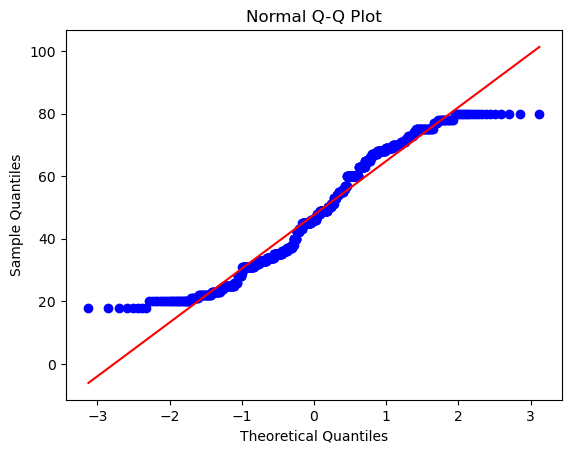

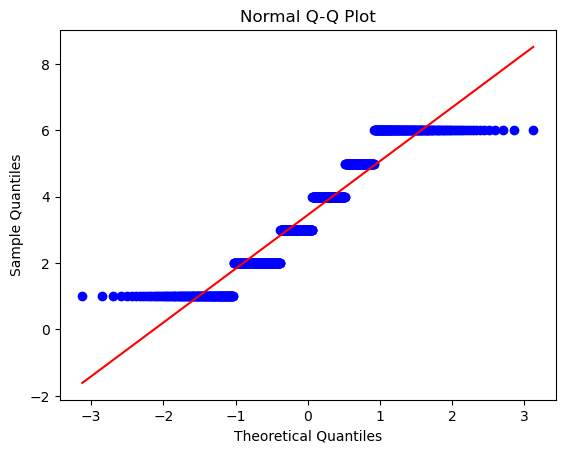

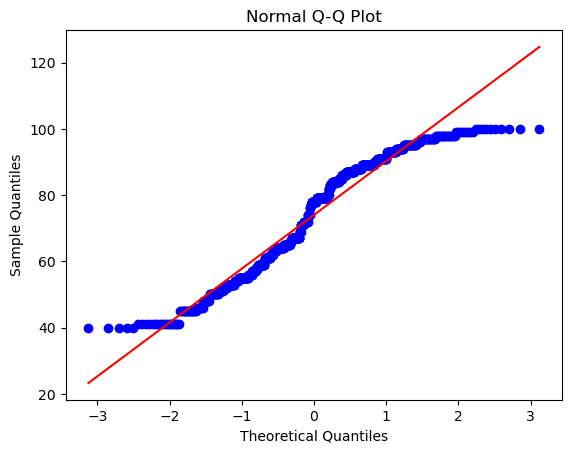

In [82]:
# Vemos la distribucion de los datos para edad #
stats.probplot(df_ponderado["edad"], dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# Vemos la distribucion de los datos para cantidad de integrantes en el hogar #
stats.probplot(df_ponderado["cantidad_de_integrantes_en_el_hogar"], dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# vemos la distribucion de los datos para la imagen del candidato

stats.probplot(df_ponderado["imagen_del_candidato"], dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


In [83]:
###########################################################
# Alternativa para graficar distribuciones utilizando funciones
#import matplotlib.pyplot as plt
#from scipy import stats

#columnas_qqplot = [
#    ("edad", "Edad"),
#    ("cantidad_de_integrantes_en_el_hogar", "Cantidad de integrantes del hogar"),
#    ("imagen_del_candidato", "Imagen del candidato"),
#]
#for col, nombre_legible in columnas_qqplot:
#    if col in df_ponderado.columns:
#        datos = pd.to_numeric(df_ponderado[col], errors="coerce").dropna()
#        if len(datos) > 0:
#            try:
#                stats.probplot(datos, dist="norm", plot=plt)
#                plt.title(f"Normal Q-Q Plot: {nombre_legible}")
#                plt.xlabel("Quantiles teóricos")
#                plt.ylabel("Quantiles muestrales")
#                plt.show()
#            except Exception as e:
#                print(f"Error al graficar Q-Q Plot de {nombre_legible}: {e}")
#        else:
#            print(f"No hay datos válidos para graficar Q-Q Plot de {nombre_legible}\n")
#    else:
#        print(f"La columna '{col}' no existe en el DataFrame.\n")

In [84]:
from scipy.stats import shapiro, kstest
data_para_test = df_ponderado ["edad"]
data_para_test

0      77
1      22
2      34
3      56
4      35
       ..
768    46
769    49
770    49
771    31
772    73
Name: edad, Length: 773, dtype: Int64

In [85]:
# Test de Shapiro - Wilk 
shapiro_test = shapiro(data_para_test)
print(f"Shapiro-Wilk test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Shapiro-Wilk test: W=0.9543692381448192, p-value=9.489964621098898e-15


In [86]:
#test de Kolmogorov-Smirnov
ks_test = kstest(data_para_test, 'norm', args=(np.mean(data_para_test), np.std(data_para_test)))
print(f"Kolmogorov-Smirnov test: D={ks_test.statistic}, p-value={ks_test.pvalue}")

Kolmogorov-Smirnov test: D=0.10670158117110767, p-value=4.059959767503868e-08


In [87]:
#####################################################
# Alternativa para pruebas de normalidad utilizando funciones
#from scipy.stats import shapiro, kstest

#col_test = "edad"
#if col_test in df_ponderado.columns:
#    data_para_test = pd.to_numeric(df_ponderado[col_test], errors="coerce").dropna()
#    cantidad = len(data_para_test)
#    print(f"Cantidad de datos válidos para '{col_test}': {cantidad}")
#    if cantidad < 3:
#        print("No se puede realizar el test de Shapiro: se requieren al menos 3 datos numéricos válidos.\n")
#    else:
#        try:
#            stat_shapiro, p_shapiro = shapiro(data_para_test)
#            print(f"Shapiro-Wilk test para '{col_test}': estadístico={stat_shapiro:.5f}, p-valor={p_shapiro:.5f}")
#            if p_shapiro < 0.05:
#                print("→ Los datos NO parecen provenir de una distribución normal (nivel 0.05)\n")
#            else:
#                print("→ No se rechaza la normalidad (nivel 0.05)\n")
#        except Exception as e:
#            print(f"Error en el test de Shapiro para '{col_test}': {e}\n")
#    # Test K-S solo si supera algún mínimo de datos
#    if cantidad > 0:
#        try:
#            # Usamos media y desvío para comparar contra una normal teórica
#            mean = data_para_test.mean()
#            std = data_para_test.std()
#            stat_ks, p_ks = kstest(data_para_test, 'norm', args=(mean, std))
#            print(f"Kolmogorov-Smirnov test para '{col_test}': estadístico={stat_ks:.5f}, p-valor={p_ks:.5f}")
#            if p_ks < 0.05:
#                print("→ Los datos NO parecen provenir de una normal teórica (nivel 0.05)")
#            else:
#                print("→ No se rechaza la normalidad teórica (nivel 0.05)")
#        except Exception as e:
 #           print(f"Error en el test de Kolmogorov-Smirnov para '{col_test}': {e}\n")
#else:
#    print(f"La columna '{col_test}' no existe en el DataFrame.")

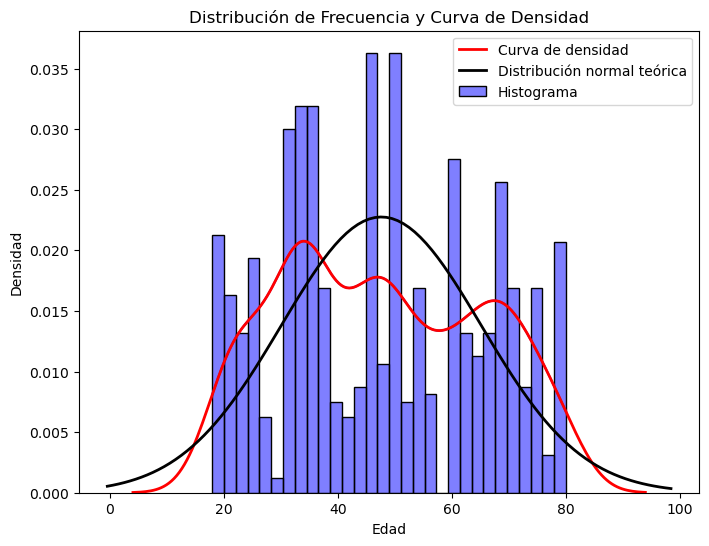

In [88]:
# Plot de la distribución de frecuencia con histograma y curva de densidad
plt.figure(figsize=(8,6))

# Histograma con curva de densidad
sns.histplot(data_para_test, kde=True, stat="density", color="blue", bins=30, label="Histograma")
sns.kdeplot(data_para_test, color="red", lw=2, label="Curva de densidad")

# Añadir la curva de una distribución normal teórica para comparar
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(data_para_test), np.std(data_para_test))
plt.plot(x, p, 'k', lw=2, label="Distribución normal teórica")

# Personalización del gráfico
plt.title('Distribución de Frecuencia y Curva de Densidad')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()

plt.show()

In [89]:
#############################################################
# Alternativa para graficar distribuciones de frecuencia utilizando funciones
#import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sns
#from scipy import stats

# Nombre de la columna a graficar
#columna_distribucion = "edad"
#if columna_distribucion in df_ponderado.columns:
#    datos = pd.to_numeric(df_ponderado[columna_distribucion], errors="coerce").dropna()
#    if len(datos) > 0:
#        try:
#            plt.figure(figsize=(8,6))
#            sns.histplot(datos, kde=True, stat="density", color="blue", bins=30, label="Histograma")
#            sns.kdeplot(datos, color="red", lw=2, label="Curva de densidad")
#            xmin, xmax = plt.xlim()
#            x = np.linspace(xmin, xmax, 100)
#            p = stats.norm.pdf(x, np.mean(datos), np.std(datos))
#            plt.plot(x, p, 'k', lw=2, label="Distribución normal teórica")
#            plt.title(f'Distribución de Frecuencia y Curva de Densidad - {columna_distribucion.capitalize()}')
#            plt.xlabel(columna_distribucion.capitalize())
#            plt.ylabel('Densidad')
#            plt.legend()
#            plt.show()
#        except Exception as e:
#            print(f"Error al graficar la distribución de {columna_distribucion}: {e}")
#    else:
#        print(f"No hay datos numéricos válidos para graficar la distribución de {columna_distribucion}\n")
#else:
#    print(f"La columna '{columna_distribucion}' no existe en el DataFrame.\n")

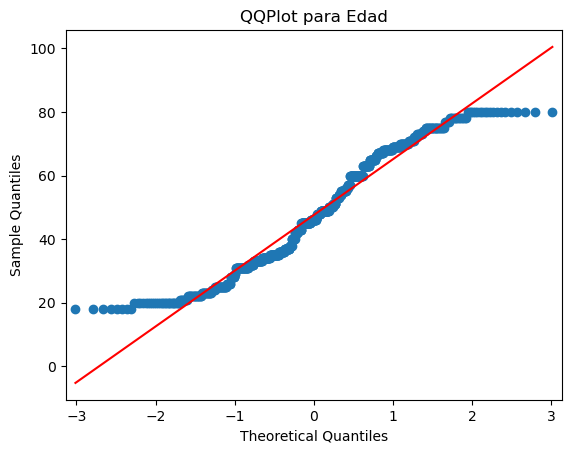

c:\Users\tomas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\tomas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\tomas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\tomas\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tomas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\tomas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, ax

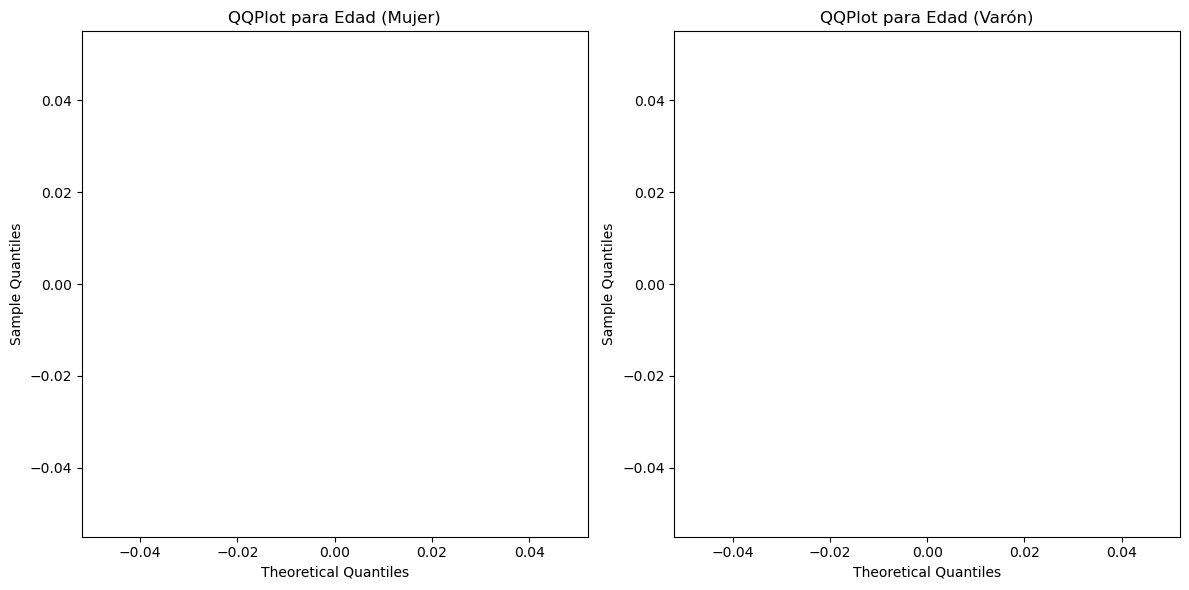

In [90]:
#Homocestacidad en las variables 
import pingouin as pg
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

#Volvemos a utilizar el dataframe de encuestas ponderado
qqplot(df_ponderado['edad'], line='s')
plt.title("QQPlot para Edad")
plt.show()

#Filtrar los datos por sexo
ejercicio_mujer = df_ponderado[df_ponderado['sexo'] == 'F']['edad']
ejercicio_varon = df_ponderado[df_ponderado['sexo'] == 'M']['edad']

# Crear la figura para los dos QQPlots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# QQPlot para mujeres
sm.qqplot(ejercicio_mujer, line='s', ax=axes[0])
axes[0].set_title("QQPlot para Edad (Mujer)")

# QQPlot para varones
sm.qqplot(ejercicio_varon, line='s', ax=axes[1])
axes[1].set_title("QQPlot para Edad (Varón)")

plt.tight_layout()
plt.show()


In [91]:
###############################################################################################
# Alternativa para graficar homocedasticidad utilizando funciones
#import matplotlib.pyplot as plt
#import pandas as pd
#import statsmodels.api as sm

#col_edad = "edad"
#col_sexo = "sexo"

# Validar existencia de columnas
#if all(col in df_ponderado.columns for col in [col_edad, col_sexo]):
    # Normalizar sexo
    #df_ponderado[col_sexo] = df_ponderado[col_sexo].astype(str).str.strip().str.upper()
    # Datos generales
    #edad_total = pd.to_numeric(df_ponderado[col_edad], errors="coerce").dropna()
    #if len(edad_total) > 0:
    #    sm.graphics.qqplot(edad_total, line='s')
    #    plt.title(f"QQPlot para {col_edad.capitalize()} (total)")
    #    plt.show()
    #else:
    #    print(f"No hay datos numéricos válidos de {col_edad} para el QQ plot general\n")
    # Por sexo
    #sexos = {'F': 'Mujer', 'M': 'Varón'}
    #fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #for idx, (sexo_cod, sexo_label) in enumerate(sexos.items()):
    #    datos_sexo = pd.to_numeric(df_ponderado[df_ponderado[col_sexo] == sexo_cod][col_edad], errors="coerce").dropna()
    #    if len(datos_sexo) > 0:
    #        sm.qqplot(datos_sexo, line='s', ax=axes[idx])
    #        axes[idx].set_title(f"QQPlot para Edad ({sexo_label})")
    #    else:
    #        axes[idx].text(0.5, 0.5, f"Sin datos válidos para {sexo_label}", 
    #                       ha='center', va='center', fontsize=12)
    #        axes[idx].set_title(f"QQPlot para Edad ({sexo_label})")
    #plt.tight_layout()
    #plt.show()
#else:
#    print(f"Las columnas '{col_edad}' y/o '{col_sexo}' no existen en el DataFrame.")

In [92]:
# Testeo de normalidad de 'sdad' por grupo de 'sexo'
shapiro_test_sexo = df_ponderado.groupby('sexo')['edad'].apply(stats.shapiro)
print("Shapiro-Wilk test para edad por sexo:")
shapiro_test_sexo

Shapiro-Wilk test para edad por sexo:


sexo
femenino      (0.9492794134991138, 3.315972966883279e-10)
masculino    (0.9477658644153181, 1.7400992375567443e-10)
Name: edad, dtype: object

In [93]:
# para el testeo de normalidad por grupo utilizando funciones
#from scipy.stats import shapiro
#import pandas as pd

#col_edad = "edad"
#col_sexo = "sexo"

#if all(col in df_ponderado.columns for col in [col_edad, col_sexo]):
#    # Normalizar sexo por seguridad
#    df_ponderado[col_sexo] = df_ponderado[col_sexo].astype(str).str.strip().str.upper()
#    resultados = {}
#    for sexo_val in df_ponderado[col_sexo].unique():
#        datos = pd.to_numeric(df_ponderado[df_ponderado[col_sexo] == sexo_val][col_edad], errors="coerce").dropna()
#        n = len(datos)
#        print(f"\nGrupo sexo: {sexo_val}, N datos: {n}")
#        if n < 3:
#            print("No se puede realizar el test de Shapiro-Wilk (mínimo 3 datos requeridos).")
#            resultados[sexo_val] = None
#        else:
#            try:
#                stat, p_val = shapiro(datos)
#                print(f"Estadístico Shapiro: {stat:.5f}, p-valor: {p_val:.5f}")
#                if p_val < 0.05:
#                    print("→ NO se ajusta a normal (nivel 0.05).")
#                else:
#                    print("→ No se rechaza la normalidad (nivel 0.05).")
#                resultados[sexo_val] = (stat, p_val)
#            except Exception as e:
#                print(f"Error en test Shapiro-Wilk para {sexo_val}: {e}")
#                resultados[sexo_val] = None
#else:
#    print(f"Las columnas '{col_edad}' o '{col_sexo}' no existen en el DataFrame.")

## 6.6 Regresión Lineal y Test de Hipotesis ####

Text(0, 0.5, 'imagen_del_candidato')

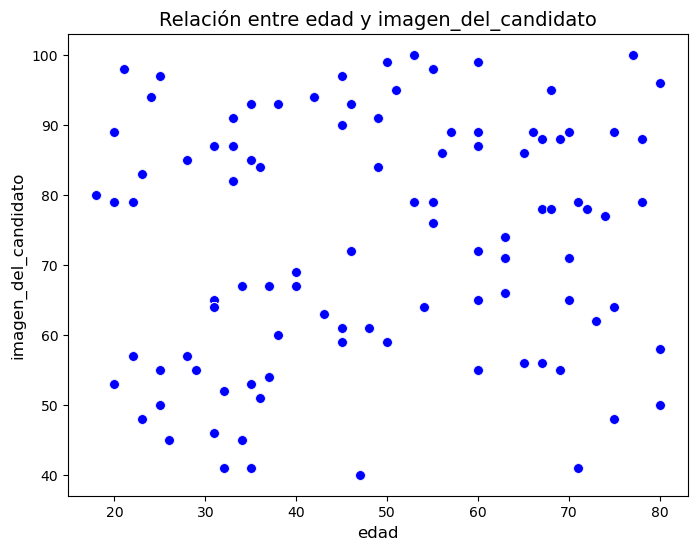

In [94]:
#Regresion Lineal entre edad e imagen del candidato
#Clonamso el dataframe ponderado para regresion
encuesta_regresion = df_ponderado
#usamos las variables edad e imagen del candidato
x_var = 'edad'
y_var = 'imagen_del_candidato'
# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=encuesta_regresion[x_var], y=encuesta_regresion[y_var], s=50, color='blue')

# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var} y {y_var}', fontsize=14)
plt.xlabel(x_var, fontsize=12)
plt.ylabel(y_var, fontsize=12)

In [95]:
##################################################################
# Alternativa para graficar regresiones lineales utilizando funciones
#import matplotlib.pyplot as plt
#import seaborn as sns
#import pandas as pd

# Variables involucradas
#x_var = 'edad'
#y_var = 'imagen_del_candidato'

# Validación de columnas
#if all(var in df_ponderado.columns for var in [x_var, y_var]):
    # Sólo datos numéricos válidos y sin nulos
#    datos_validos = df_ponderado[[x_var, y_var]].copy()
#    datos_validos[x_var] = pd.to_numeric(datos_validos[x_var], errors='coerce')
#    datos_validos[y_var] = pd.to_numeric(datos_validos[y_var], errors='coerce')
#    datos_validos = datos_validos.dropna()

#    if not datos_validos.empty:
#        plt.figure(figsize=(8, 6))
#        sns.scatterplot(x=datos_validos[x_var], y=datos_validos[y_var], s=50, color='blue')
#        plt.title(f'Relación entre {x_var} y {y_var}', fontsize=14)
#        plt.xlabel(x_var, fontsize=12)
#        plt.ylabel(y_var, fontsize=12)
#        plt.show()
#    else:
#        print(f"No hay datos válidos para graficar {x_var} contra {y_var}.\n")
#else:
#    print(f"Las columnas '{x_var}' o '{y_var}' no existen en el DataFrame.\n")

In [96]:
#Calcular la correlación de Pearson
correlacion_pearson = encuesta_regresion[x_var].corr(encuesta_regresion[y_var])
print(f'Correlación de Pearson entre {x_var} y {y_var}: {correlacion_pearson:.2f}')

Correlación de Pearson entre edad y imagen_del_candidato: 0.11


In [97]:
#####################################################################################
# Alternativa para calcular la correlación de Pearson utilizando funciones
#import pandas as pd

#x_var = 'edad'
#y_var = 'imagen_del_candidato'

#if all(var in encuesta_regresion.columns for var in [x_var, y_var]):
#    # Convertir a numérico y eliminar nulos en ambos
#    df_corr = encuesta_regresion[[x_var, y_var]].copy()
#    df_corr[x_var] = pd.to_numeric(df_corr[x_var], errors='coerce')
#    df_corr[y_var] = pd.to_numeric(df_corr[y_var], errors='coerce')
#    df_corr = df_corr.dropna()
#    if not df_corr.empty:
#        correlacion_pearson = df_corr[x_var].corr(df_corr[y_var])
#        print(f'Correlación de Pearson entre {x_var} y {y_var}: {correlacion_pearson:.2f}')
#    else:
#        print(f"No hay datos numéricos válidos para calcular la correlación entre {x_var} y {y_var}.")
#else:
#    print(f"Las columnas '{x_var}' o '{y_var}' no existen en el DataFrame.")

In [98]:
#Ajustar el modelo de regresión lineal
X_simple_edad = sm.add_constant(encuesta_regresion[x_var].astype(float))  # Añadir la constante
modelo_simple_edad = sm.OLS(encuesta_regresion[y_var], X_simple_edad).fit()

In [99]:
###############################################################################################
# Alternativa para ajustar modelos de regresión lineal utilizando funciones
#import statsmodels.api as sm
#import pandas as pd

#x_var = 'edad'
#y_var = 'imagen_del_candidato'

#if all(var in encuesta_regresion.columns for var in [x_var, y_var]):
#    # Seleccionar datos numéricos válidos y eliminar nulos
#    X = pd.to_numeric(encuesta_regresion[x_var], errors='coerce')
#    y = pd.to_numeric(encuesta_regresion[y_var], errors='coerce')
#    datos_validos = pd.concat([X, y], axis=1).dropna()
#    if len(datos_validos) > 1:  # Se necesita más de 1 punto para OLS
#        X_reg = sm.add_constant(datos_validos[x_var])
#        y_reg = datos_validos[y_var]
#        modelo = sm.OLS(y_reg, X_reg).fit()
#        print(modelo.summary())
#    else:
#        print("No hay suficientes datos válidos para ajustar la regresión lineal.")
#else:
#    print(f"Las columnas '{x_var}' o '{y_var}' no existen en el DataFrame.")

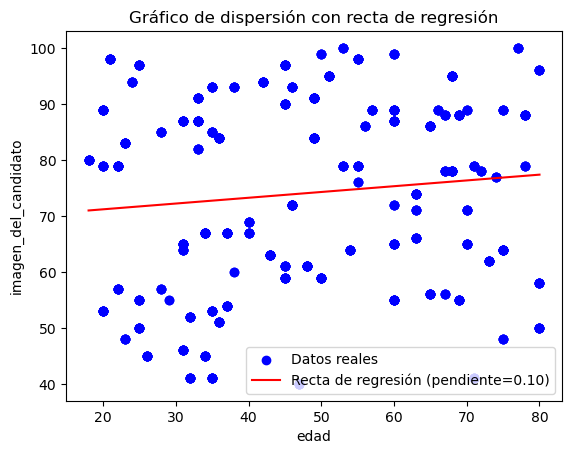

In [100]:
# Generar la recta de regresión
plt.scatter(encuesta_regresion[x_var], encuesta_regresion[y_var], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_edad.params
x_vals = np.linspace(encuesta_regresion[x_var].min(), encuesta_regresion[x_var].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()


In [101]:
################################################################################################
# Alternativa para graficar la recta de regresión utilizando funciones
#import numpy as np
#import matplotlib.pyplot as plt
#import pandas as pd

#x_var = 'edad'
#y_var = 'imagen_del_candidato'

# Asumimos que el modelo ya está definido como "modelo", usando el último bloque robusto.
#if all(var in encuesta_regresion.columns for var in [x_var, y_var]):
#    # Solo datos válidos y numéricos
#    X_plot = pd.to_numeric(encuesta_regresion[x_var], errors='coerce')
#    Y_plot = pd.to_numeric(encuesta_regresion[y_var], errors='coerce')
#    datos_plot = pd.concat([X_plot, Y_plot], axis=1).dropna()
#    if not datos_plot.empty and 'modelo' in locals():  # Nos aseguramos que la regresión sí se ajustó
#        plt.figure(figsize=(8,6))
#        plt.scatter(datos_plot[x_var], datos_plot[y_var], label='Datos reales', color='blue')
#        try:
#            params = modelo.params
#            if len(params) == 2:
#                intercepto, pendiente = params
#                x_vals = np.linspace(datos_plot[x_var].min(), datos_plot[x_var].max(), 100)
#                y_vals = intercepto + pendiente * x_vals
#                plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')
#            else:
#                print("Error: los parámetros del modelo no son los esperados (largo diferente de 2). No se dibuja la recta.")
#        except Exception as e:
#            print(f"Error extrayendo parámetros del modelo: {e}")
#        plt.xlabel(x_var)
#        plt.ylabel(y_var)
#        plt.title('Gráfico de dispersión con recta de regresión')
#        plt.legend()
#        plt.show()
#    else:
#        print("No hay datos numéricos válidos para graficar, o la regresión no se ajustó exitosamente.")
#else:
#    print(f"Las columnas '{x_var}' o '{y_var}' no existen en el DataFrame.")

In [103]:
print(modelo_simple_edad.summary())

                             OLS Regression Results                             
Dep. Variable:     imagen_del_candidato   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                  0.011
Method:                   Least Squares   F-statistic:                     9.211
Date:                  mar, 25 nov 2025   Prob (F-statistic):            0.00249
Time:                          09:27:50   Log-Likelihood:                -3266.0
No. Observations:                   773   AIC:                             6536.
Df Residuals:                       771   BIC:                             6545.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.1177      1.725

In [ ]:
# Regresion lineal entre sexo e imagen del candidato
df_regresion_sexo = df_ponderado.copy()
df_regresion_sexo ['sexo_numerico'] = df_regresion_sexo['sexo'].map({'femenino': 0, 'masculino': 1})
print(df_regresion_sexo[['sexo', 'sexo_numerico']].head())
print(df_regresion_sexo[['sexo_numerico']].dtypes)

        sexo  sexo_numerico
0   femenino              0
1   femenino              0
2  masculino              1
3   femenino              0
4  masculino              1
sexo_numerico    int64
dtype: object


Text(0, 0.5, 'sexo_numerico')

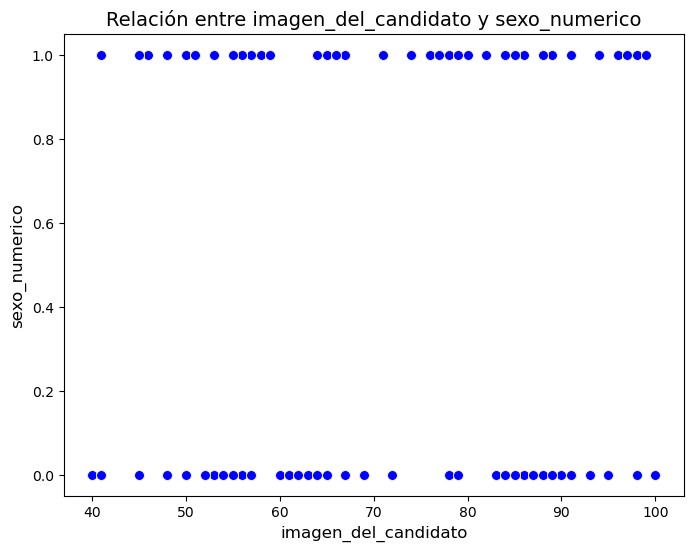

In [ ]:
# Establecemos las varaibles imagen del candidato y sexo numerico
x_var_2 = 'imagen_del_candidato'
y_var_2 = 'sexo_numerico'

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_regresion_sexo[x_var_2], y=df_regresion_sexo[y_var_2], s=50, color='blue')

# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var_2} y {y_var_2}', fontsize=14)
plt.xlabel(x_var_2, fontsize=12)
plt.ylabel(y_var_2, fontsize=12)

In [ ]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_sexo[x_var_2].corr(df_regresion_sexo[y_var_2])
print(f'Correlación de Pearson entre {x_var_2} y {y_var_2}: {correlacion_pearson:.2f}')

Correlación de Pearson entre imagen_del_candidato y sexo_numerico: -0.02


In [ ]:
#Ajustar el modelo de regresión lineal
X_simple_sexo = sm.add_constant(df_regresion_sexo[x_var_2]).astype(float)  # Añadir la constante
modelo_simple_sexo = sm.OLS(df_regresion_sexo[y_var_2], X_simple_sexo).fit()

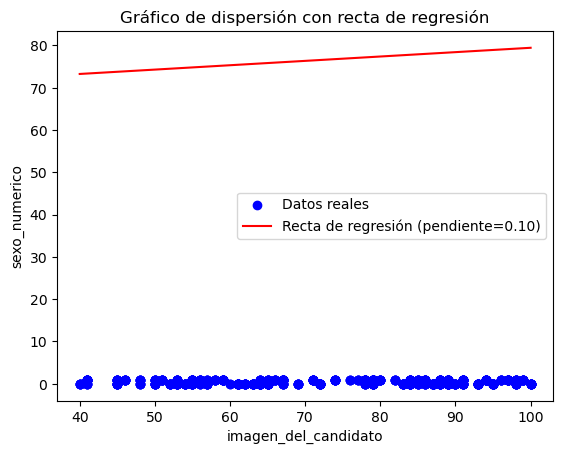

In [ ]:
# Generar la recta de regresión
plt.scatter(df_regresion_sexo[x_var_2], df_regresion_sexo[y_var_2], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_secundaria.params
x_vals = np.linspace(df_regresion_sexo[x_var_2].min(), df_regresion_sexo[x_var_2].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var_2)
plt.ylabel(y_var_2)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [ ]:
print(modelo_simple_secundaria_2.summary())

                            OLS Regression Results                            
Dep. Variable:          sexo_numerico   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3375
Date:                mar, 25 nov 2025   Prob (F-statistic):              0.561
Time:                        02:33:10   Log-Likelihood:                -560.85
No. Observations:                 773   AIC:                             1126.
Df Residuals:                     771   BIC:                             1135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5497 

In [ ]:
#Regresion Lineal 3 entre edad y nivel educativo
df_regresion_educacion = df_ponderado.copy()
print(df_regresion_educacion["nivel_educativo"].unique())
df_regresion_educacion['nivel_educativo_numerico'] = df_regresion_educacion['nivel_educativo'].map({"Primario incompleto": 1,
                                                                                                    "Primario completo": 2,
                                                                                                    "Secundario incompleto": 3,
                                                                                                    "Secundario completo": 4,
                                                                                                    "Terciario/Universitario incompleto": 5,
                                                    "Terciario/Universitario completo": 6,
                                                    "Posgrado": 7,
                                                    "universitario completo": 8})
print(df_regresion_educacion[['nivel_educativo', 'nivel_educativo_numerico']].head())


['Terciario/Universitario completo' 'Terciario/Universitario incompleto'
 'Primario incompleto' 'Secundario incompleto' 'Secundario completo'
 'Posgrado' 'Primario completo']
                      nivel_educativo  nivel_educativo_numerico
0    Terciario/Universitario completo                         6
1  Terciario/Universitario incompleto                         5
2                 Primario incompleto                         1
3               Secundario incompleto                         3
4               Secundario incompleto                         3


In [ ]:
print(df_regresion_educacion[['nivel_educativo_numerico']].dtypes)

nivel_educativo_numerico    int64
dtype: object


Text(0, 0.5, 'imagen_del_candidato')

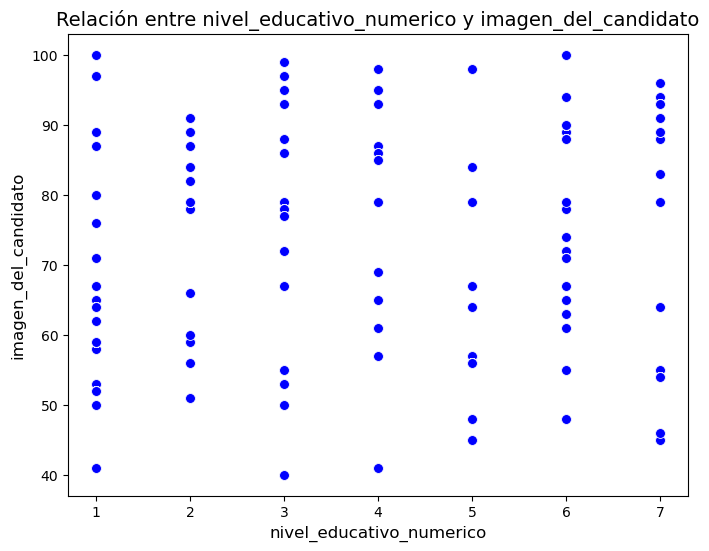

In [ ]:
# Establecemos las varaibles imagen del candidato y sexo numerico
x_var_3 = 'nivel_educativo_numerico'
y_var_3 = 'imagen_del_candidato'

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_regresion_educacion[x_var_3], y=df_regresion_educacion[y_var_3], s=50, color='blue')

# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var_3} y {y_var_3}', fontsize=14)
plt.xlabel(x_var_3, fontsize=12)
plt.ylabel(y_var_3, fontsize=12)

In [ ]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_educacion[x_var_3].corr(df_regresion_educacion[y_var_3])
print(f'Correlación de Pearson entre {x_var_3} y {y_var_3}: {correlacion_pearson:.2f}')

Correlación de Pearson entre nivel_educativo_numerico y imagen_del_candidato: 0.07


In [ ]:
#Ajustar el modelo de regresión lineal
X_simple_educacion = sm.add_constant(df_regresion_educacion[x_var_3]).astype(float)  
modelo_simple_educacion= sm.OLS(df_regresion_educacion[y_var_3], X_simple_educacion).fit()

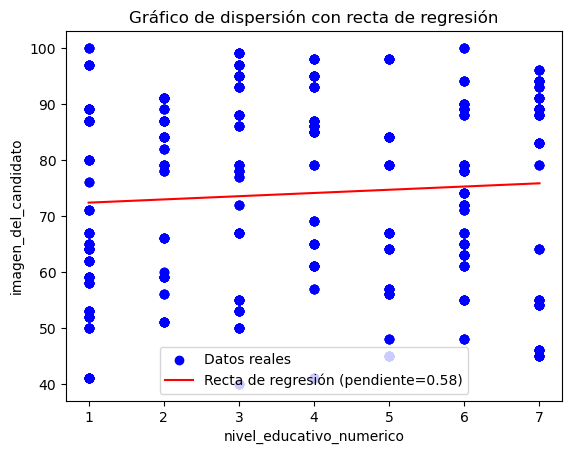

In [ ]:
# Generar la recta de regresión
plt.scatter(df_regresion_educacion[x_var_3], df_regresion_educacion[y_var_3], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_educacion.params
x_vals = np.linspace(df_regresion_educacion[x_var_3].min(), df_regresion_educacion[x_var_3].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var_3)
plt.ylabel(y_var_3)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [ ]:
print(modelo_simple_educacion.summary())

                             OLS Regression Results                             
Dep. Variable:     imagen_del_candidato   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.004
Method:                   Least Squares   F-statistic:                     4.013
Date:                  mar, 25 nov 2025   Prob (F-statistic):             0.0455
Time:                          02:33:11   Log-Likelihood:                -3268.6
No. Observations:                   773   AIC:                             6541.
Df Residuals:                       771   BIC:                             6551.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

Text(0, 0.5, 'edad')

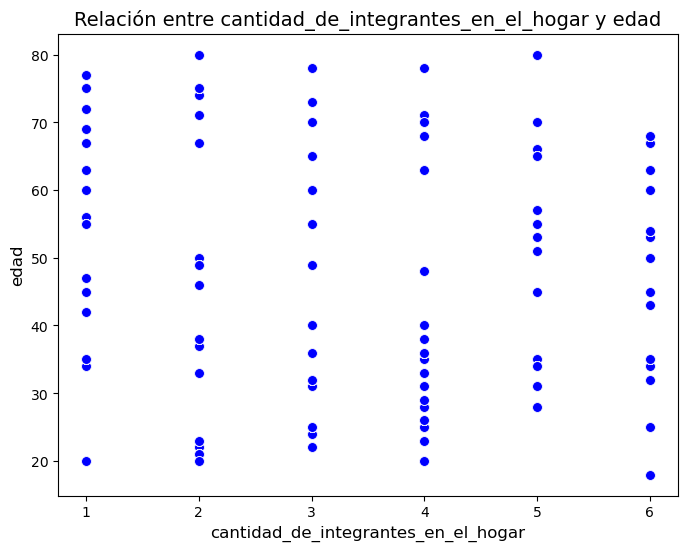

In [ ]:
# Regresion lineal 4 entre cantidad de integrantes en el hogar e imagen del candidato
df_regresion_hogar = df_ponderado.copy()
#usamos las variables edad e imagen del candidato
x_var_4 = 'cantidad_de_integrantes_en_el_hogar'
y_var_4 = 'edad'
# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_regresion_hogar[x_var_4], y=df_regresion_hogar[y_var_4], s=50, color='blue')
# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var_4} y {y_var_4}', fontsize=14)
plt.xlabel(x_var_4, fontsize=12)
plt.ylabel(y_var_4, fontsize=12)

In [ ]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_hogar[x_var_4].corr(df_regresion_hogar[y_var_4])
print(f'Correlación de Pearson entre {x_var_4} y {y_var_4}: {correlacion_pearson:.2f}')


Correlación de Pearson entre edad y imagen_del_candidato: 0.11


In [ ]:
#Ajustar el modelo de regresión lineal
X_simple_hogar = sm.add_constant(df_regresion_hogar[x_var_4].astype(float))
modelo_simple_hogar = sm.OLS(df_regresion_hogar[y_var_4], X_simple_hogar).fit()

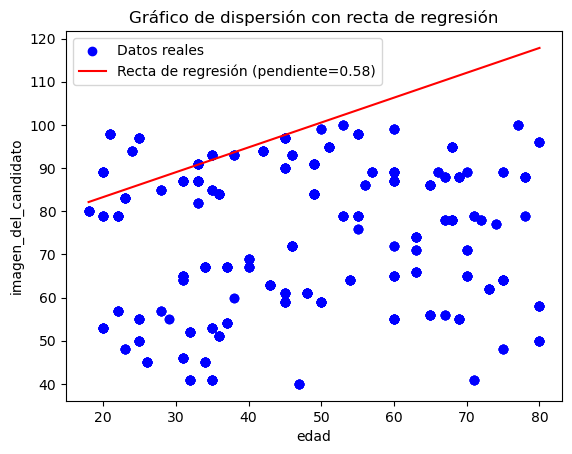

In [ ]:
# Generar la recta de regresión
plt.scatter(df_regresion_hogar[x_var_4], df_regresion_hogar[y_var_4], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_educacion.params
x_vals = np.linspace(df_regresion_hogar[x_var_4].min(), df_regresion_hogar[x_var_4].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var_4)
plt.ylabel(y_var_4)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [ ]:
print(modelo_simple_hogar.summary())

                            OLS Regression Results                            
Dep. Variable:                   edad   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.915
Date:                mar, 25 nov 2025   Prob (F-statistic):            0.00872
Time:                        02:36:17   Log-Likelihood:                -3307.4
No. Observations:                 773   AIC:                             6619.
Df Residuals:                     771   BIC:                             6628.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [ ]:
# Regresion lineal 5  entre imagen del candidato y cantidad de integrantes en el hogar
 df_regresion_candidato = df_ponderado.copy()
    df_regresion_candidato
    #usamos las variables edad e imagen del candidato
    x_var_5 = 'cantidad_de_integrantes_en_el_hogar'
    y_var_5 = 'imagen_del_candidato'
    # Gráfico de dispersión
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x= df_regresion_candidato[x_var_5], y=df_regresion_candidato[y_var_5], s=50, color='blue')
    # Etiquetas y título del gráfico
    plt.title(f'Relación entre {x_var_5} y {y_var_5}', fontsize=14)
    plt.xlabel(x_var_5, fontsize=12)
    plt.ylabel(y_var_5, fontsize=12)

IndentationError: unexpected indent (1855915147.py, line 2)

In [ ]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_candidato[x_var_5].corr(df_regresion_candidato[y_var_5])
print(f'Correlación de Pearson entre {x_var_5} y {y_var_5}: {correlacion_pearson:.2f}')

Correlación de Pearson entre imagen_del_candidato y cantidad_de_integrantes_en_el_hogar: 0.06


In [ ]:
#Ajustar el modelo de regresión lineal
X_simple_candidato = sm.add_constant(df_regresion_candidato[x_var_5])
modelo_simple_candidato = sm.OLS(df_regresion_candidato[y_var_5], X_simple_candidato).fit()

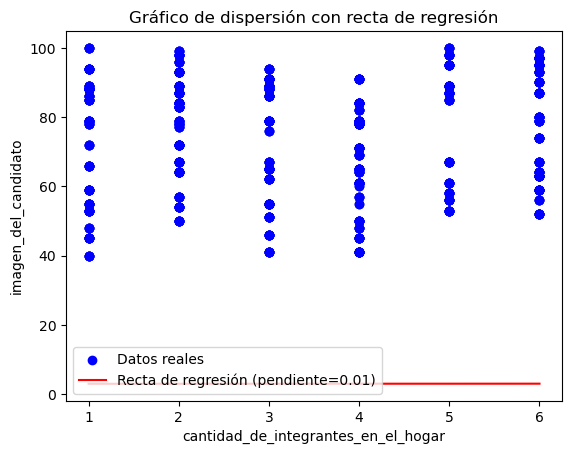

In [ ]:
# Generar la recta de regresión
plt.scatter(df_regresion_candidato[x_var_5], df_regresion_candidato[y_var_5], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_candidato.params
x_vals = np.linspace(df_regresion_candidato[x_var_5].min(), df_regresion_candidato[x_var_5].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var_5)
plt.ylabel(y_var_5)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [ ]:
print(modelo_simple_candidato.summary())

                                     OLS Regression Results                                    
Dep. Variable:     cantidad_de_integrantes_en_el_hogar   R-squared:                       0.004
Model:                                             OLS   Adj. R-squared:                  0.003
Method:                                  Least Squares   F-statistic:                     3.125
Date:                                 mar, 25 nov 2025   Prob (F-statistic):             0.0775
Time:                                         02:33:13   Log-Likelihood:                -1503.6
No. Observations:                                  773   AIC:                             3011.
Df Residuals:                                      771   BIC:                             3021.
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                           coef    std e

## 6.7 Regresion Lineal Multiple y Regresion Logistica ####

In [ ]:
# Regresion logistica entre voto limpio y las variables edad, sexo, estrato y nivel educativo



In [ ]:
# Regresion Lineal Multiple entre edad, estrato, sexo y nivel educativo con imagen del candidato